<a id='start'></a> 
# Relations de dispersion dans un plasma maxwellien isotrope

1. [Liens utiles](#liens-utiles)
1. [Routines](#routines)    
1. [Paramètres magnétoplasma froid](#params-magnetoplasma-froid)
1. [End](#end) 


In [1]:
#%matplotlib inline
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
import scipy.special as sp
import scipy.optimize as opt

from plasmapy.dispersion import plasma_dispersion_func as Zplasmapy

import mpmath as mp

from lib_plasma.dispersion import (plasma_parameters, cold_plasma_params, cold_plasma_dispersion_stuff)

<a id='liens-utiles'></a> 
### Liens utiles [previous](#start) [next](#routines)

Roch:  
https://drive.google.com/drive/folders/16fZ-ECyn6EsHZR9mbK4OdAYK5ICUgdws

https://github.com/rochSmets/GH_whampyr

Recherche de zéros:  
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html?highlight=fsolve#scipy.optimize.fsolve

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root.html?highlight=root#scipy.optimize.root

https://mpmath.org/
https://mpmath.org/doc/current/calculus/optimization.html

Fonctions spéciales:  
https://docs.scipy.org/doc/scipy/reference/special.html  
https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.wofz.html#scipy.special.wofz  
http://ab-initio.mit.edu/wiki/index.php/Faddeeva_Package  
exp(-z^2) * erfc(-i*z)

## Contantes de base

National Institute of Standards and Technology: http://physics.nist.gov/cuu/Constants/index.html  
CODATA Internationally recommended 2014 values of the Fundamental Physical Constants (12/11/2018)

In [2]:
m  = 9.10938356e-31           # kg               electron mass
M  = 1.672621898e-27          # kg               proton mass
e  = 1.6021766208e-19         # C                elementary charge    
c  = 299792458                # m/s              speed of light in vacuum
kB = 1.38064852e-23           # J/K              Boltzmann constant
G  = 6.67408e-11              # m^3/kg/s^2       Newtonian constant of gravitation

mu = M/m                      #                  proton-electron mass ratio 

mu0 = 4*np.pi*1e-7            # N/A^2            magnetic constant
epsi0 = 1/(mu0*c*c)           # F/m              electric constant

<a id='routines'></a> 
### Routines [start](#start) [next](#params-magnetoplasma-froid) [end](#end) 

In [3]:
def Fried_et_Conte_Z_v1(z):
    return 1j * np.sqrt(np.pi) * np.exp(-z**2) * sp.erfc(-1j*z)    

def W_Ichimaru_v1(z):
    z = z / np.sqrt(2) 
    return 1 + z*Fried_et_Conte_Z_v1(z)

def Fried_et_Conte_Z(z):
    """
    Faddeeva function (W function in Abramowitz and Stegun) 
    http://ab-initio.mit.edu/Faddeeva    
    """
    return 1j * np.sqrt(np.pi) * sp.wofz(z)

def W_Ichimaru(z):
    z = z / np.sqrt(2) 
    return 1 + z*Fried_et_Conte_Z(z)

def Lambda(n, z):
    """
    iv(n, z) is the modified Bessel function of first kind 
    of nth order = (-1j)**n * Jn(1j*z)    
    """
    return np.exp(-z) * sp.iv(n, z)

def Lambda1(n, z):
    """
    1st dérivative of Lambda with respect to z 
    """
    return np.exp(-z) * ( -sp.iv(n, z) + (sp.iv(n-1, z)+sp.iv(n+1, z))/2 )

def sign_func(x):
    s = np.sign(x)    
    return s if s != 0 else 1 

class ChiOneSpecies():
    """
    species susceptibility tensor CHI_s is normalized to (Wpe/w)^2 :    
        chi_s = CHI_s * (w/Wpe)^2           
    species gyrofrequency Wcs is normalized to Wpe:
        xcs = Wcs/ Wpe              
    species plasma frequency Wps is normalized to Wpe:
        xps = Wps/ Wpe   
    species thermal velocity Vths is normalized to c, the speed of light:
        vths = Vths/c        
    wavefrequency w is normalized to Wpe, the electron plasma frequency:
        x = w/Wpe    
    wavenumber k is normalized to the inverse of c/Wpe = lambdae, the electron inertial length:
        n = k*lambdae      
    """       
    def __init__(self, name):
        self.name = name

class ChiCold_s(ChiOneSpecies):     
    def __init__(self, name, xcs=0.1, xps=1.):
        super().__init__("ChiCold_"+name)
        self.xcs = xcs
        self.xps = xps                
    
    def __call__(self, x):
        chi = np.zeros(6, dtype=complex)
        chi[0] = -1 / (1 - (self.xcs/x)**2)     # c_xx 
        chi[1] =  1 * chi[0]                    # c_yy     
        chi[2] = -1                             # c_zz 
        chi[3] = +1j * (self.xcs/x) * chi[0]    # c_xy
        #chi[4] =  0                            # c_xz
        #chi[5] =  0                            # c_yz
        return chi * self.xps**2    
       
class ChiMaxwellianIsotropic_s(ChiOneSpecies):
    """   
    Zn = (x - n*xcs) / (|npara| * vths) 
    beta_s = (nperp*vths/xcs)**2
    """      
    def __init__(self, name, xcs=0.1, xps=1., vths=1e-4, nsum=3):
        super().__init__("ChiMaxwellianIsotropic_"+name)
        self.xcs = xcs
        self.xps = xps                
        self.vths = vths                
        self.nsum = nsum                
    
    def __call__(self, nperp, npara, x):
        beta = (nperp*self.vths/self.xcs)**2
        n = np.array(range(-self.nsum, self.nsum+1, 1))
        Zn = (x - n*self.xcs) / abs(npara) / self.vths
        Z0 =  x  / abs(npara) / self.vths        
        Z0overZn = x / (x - n*self.xcs)         
        chi = np.zeros(6, dtype=complex)
        # c_xx
        chi[0] = (-1/beta) * np.sum( Z0overZn * n**2 * Lambda(n, beta) * \
                                     (1 - W_Ichimaru(Zn)) ) 
        # c_yy
        chi[1] = (-1) * np.sum( Z0overZn * (n**2/beta*Lambda(n, beta) - 2*beta*Lambda1(n, beta)) * \
                                     (1 - W_Ichimaru(Zn)) ) 
        # c_zz 
        chi[2] = Z0 * np.sum( Zn * Lambda(n, beta) * W_Ichimaru(Zn) )  
        # c_xy
        chi[3] = (-1j) * np.sum( Z0overZn * n * Lambda1(n, beta) * (1 - W_Ichimaru(Zn)) ) 
        # c_xz
        chi[4] = (-sign_func(npara)*Z0/np.sqrt(beta)) * np.sum( n * Lambda(n, beta) * (1 - W_Ichimaru(Zn)) )  
        # c_yz
        chi[5] = (+1j*sign_func(npara)*Z0*np.sqrt(beta)) * np.sum( Lambda1(n, beta) * (1 - W_Ichimaru(Zn)) )                           
        return chi * self.xps**2  
    
class EpsiDielectricTensor():     
    """
    EPSI = I + Sum(CHI_s(kperp, kpara, w))           
    dielectric tensor EPSI is normalized to (Wpe/w)^2 :     
        epsi = EPSI * (w/Wpe)^2                    
    """
    def __init__(self, name, *args):
        self.name = name        
        self.nb_species = len(args)
        self.args = args
        
    def __call__(self, nperp, npara, x):
        epsi = np.zeros(6, dtype=complex)
        epsi[0:3] = x**2 
        for i in range(self.nb_species):   
            chi_s = self.args[i]
            args_chi_s = [x] if isinstance(chi_s, ChiCold_s) else [nperp, npara, x]   
            epsi = epsi + chi_s(*args_chi_s)                   
        return epsi    
    
def dispersion_func(x, nperp, npara, epsi):
    """
    N = ck/w
    EPSI = I + Sum(CHI_s(kperp, kpara, w))
    DELTA = EPSI(kperp, kpara, w) - I_T*N^2    
        
    refractive index N is normalized to Wpe/w :   
        n = N*(w/Wpe) = k*lambdae     
    wavenumber k is normalized to the inverse of c/Wpe = lambdae, the electron inertial length :
        n = k*lambdae     
    wavefrequency w is normalized to Wpe, the electron plasma frequency :
        x = w/Wpe     
    tensors EPSI and DELTA are normalized to (Wpe/w)^2 :     
        epsi = EPSI * (w/Wpe)^2 
        delta = DELTA * (w/Wpe)^2
               
    hence: delta = epsi - I_T*n^2 
    
    with Det(delta) = 0 <=>  Det(DELTA) = 0
    """  
    epsi = epsi.__call__(nperp, npara, x)
    e_xx = epsi[0]       
    e_yy = epsi[1]     
    e_zz = epsi[2]     
    e_xy = epsi[3]     
    e_xz = epsi[4]     
    e_yz = epsi[5]    
    Det = (e_yy - nperp**2 - npara**2)*((e_xx - npara**2)*(e_zz - nperp**2) - (e_xz + npara*nperp)**2) \
        + (e_xx - npara**2)*e_yz**2  \
        + (e_zz - nperp**2)*e_xy**2  \
        + 2*(e_xz + npara*nperp)*(e_xy**2)*(e_yz**2)
    return Det  

def disp_1Dfunc_builder(nperp, npara, epsi):
    def disp_1Dfunc(x):
        return dispersion_func(x, nperp, npara, epsi) 
    return disp_1Dfunc

def dispersion_R2R2func(xR2, nperp, npara, epsi):
    x = complex(xR2[0], xR2[1])
    disp = dispersion_func(x, nperp, npara, epsi)
    return [disp.real, disp.imag]

def solverR2R2(nperp, npara, epsi, x0, method='hybr', xtol=1.49012e-8 ):
    sol = opt.root(dispersion_R2R2func, x0, args=(nperp, npara, epsi), 
                   method=method, options={'xtol': xtol})
    if sol.success != True :
        print('nperp: {:4.2f} npara: {:4.2f} -  success: {} - x : {}'.format(nperp, npara,
                                                                             sol.success, sol.x))
        sol.x = [np.nan, np.nan]
    return sol

def oneBranch(nperp_arr, npara_arr, epsi, x0, method='hybr', xtol=1.49012e-8, trend=True, dx0=None):    
    x_sol = np.zeros_like(npara_arr, dtype=complex)
    for i, (nperp, npara) in enumerate(zip(nperp_arr, npara_arr)):
        sol = solverR2R2(nperp, npara, epsi, x0, method=method, xtol=xtol)
        x_sol[i] = complex(sol.x[0], sol.x[1])
        if trend:
            if dx0 == None: dx0 = 0
            dx = x_sol[i] - x_sol[i-1] if i else dx0 
            x0 = [sol.x[0] + dx.real, sol.x[1] + dx.imag] 
        else:
            [sol.x[0], sol.x[1]]
    return x_sol

<a id='params-magnetoplasma-froid'></a> 
### Paramètres magnétoplasma froid [start](#start) [next](#load-fichier-l1) [end](#end)

In [4]:
B0 = 7e-9 
n0 = 13e6
Wps, Wcs = cold_plasma_params(B0=B0, n0=n0, ns=[1., .95, .05/2], qs=[-1, +1, +2], ms=[1./mu, 1, 4], echo=True)
Wpe, Wce = Wps[0],           Wcs[0] 
fpe, fce = Wps[0]/(2*np.pi), Wcs[0]/(2*np.pi)

disp_stuff = cold_plasma_dispersion_stuff(Wps, Wcs)
N2moins = disp_stuff["N2moins"]
N2plus = disp_stuff["N2plus"]

charge neutrality: -4.16334e-17 n0 e

fce:         195.95 Hz
fpe:       32373.03 Hz
fpe/fce:     165.21
vAlf:      42346.99 m/s

fréquences de coupure (N=0):
fR:        48559.69 Hz
fL:        16186.66 Hz


In [5]:
print(Wps/Wpe) 
print(-Wcs/Wpe)

xpe, xpp, xpa = Wps/Wpe
xce, xcp, xca = -Wcs/Wpe

[1.         0.02274612 0.00368991]
[-6.05279875e-03  3.29645723e-06  1.64822861e-06]


### Construction des tenseurs de susceptibilité par espèce

In [6]:
chi_cold_e = ChiCold_s('e- cold', xcs=xce, xps=xpe)
chi_cold_p = ChiCold_s('H+ cold', xcs=xcp, xps=xpp)
chi_cold_a = ChiCold_s('He++ cold', xcs=xca, xps=xpa)

Te = 10
vthe = np.sqrt((Te*e) / m) / c
chi_hot_e = ChiMaxwellianIsotropic_s('e- hot', xcs=xce, xps=xpe, vths=vthe, nsum=2)

Tp = 5
vthp = np.sqrt((Tp*e) / M) / c
chi_hot_p = ChiMaxwellianIsotropic_s('H+ hot', xcs=xcp, xps=xpp, vths=vthp, nsum=3)

Ta = 5
vtha = np.sqrt((Ta*e) / (4*M)) / c
chi_hot_a = ChiMaxwellianIsotropic_s('He++ hot', xcs=xca, xps=xpa, vths=vtha, nsum=3)

print(('vthe = %.2g m/s')%(vthe*c))
print(('vthp = %.2g m/s')%(vthp*c))
print(('vtha = %.2g m/s')%(vtha*c))

vthe = 1.3e+06 m/s
vthp = 2.2e+04 m/s
vtha = 1.1e+04 m/s


### Construction du tenseur diélectrique 

In [ ]:
epsi_cold_e_p = EpsiDielectricTensor('epsi_cold_e_p', chi_cold_e, chi_cold_p)
epsi_cold_e_hot_p = EpsiDielectricTensor('epsi_cold_e_hot_p', chi_cold_e, chi_hot_p)
epsi_hot_e_p = EpsiDielectricTensor('epsi_hot_e_p', chi_hot_e, chi_hot_p)

In [7]:
epsi_cold_e_p_a = EpsiDielectricTensor('epsi_cold_e_p_a', chi_cold_e, chi_cold_p, chi_cold_a)
epsi_cold_e_hot_p_a = EpsiDielectricTensor('epsi_cold_e_hot_p_a', chi_cold_e, chi_hot_p, chi_hot_a)
epsi_hot_e_p_a = EpsiDielectricTensor('epsi_hot_e_p_a', chi_hot_e, chi_hot_p, chi_hot_a)

### Résolution numérique cas froid et comparaison avec solution théorique

In [ ]:
npara = 0.2*xpp
nperp = npara/100.

In [ ]:
theta = np.deg2rad(5)
x = 0.2*xcp
nplus = np.sqrt(N2plus(x*Wpe, theta)) * x
nmoins = np.sqrt(N2moins(x*Wpe, theta)) * x
print("n+ :%f\nn- :%f"%(nplus, nmoins))

n = nplus
n = nmoins
npara = n*np.cos(theta)
nperp = n*np.sin(theta)

In [ ]:
x0 = np.array([0.80*xcp, -0.*xcp])
sol = solverR2R2(nperp, npara, epsi_cold_e_p_a, x0, xtol=1e-12)
#sol = solverR2R2(nperp, npara, epsi_hot_e_p, x0)
#sol = solverR2R2(nperp, npara, epsi_cold_e_hot_p, x0)
#sol = solverR2R2(nperp, npara, epsi_cold_e_p, x0)
sol.x / xcp

In [ ]:
sol

### Calcul numérique des branches

In [ ]:
npara_arr = np.linspace(npara, 1*npara/100, num=20)
nperp_arr = np.ones_like(npara_arr) * nperp

In [ ]:
#x1 = oneBranch(nperp_arr, npara_arr, epsi_cold_e_hot_p, x0)
x1 = oneBranch(nperp_arr, npara_arr, epsi_cold_e_p, x0)
x2 = oneBranch(nperp_arr, npara_arr, epsi_hot_e_p, x0)

In [23]:
theta = np.deg2rad(5)
x = 0.1*xcp
nplus = np.sqrt(N2plus(x*Wpe, theta)) * x
nmoins = np.sqrt(N2moins(x*Wpe, theta)) * x
print("n+ :%f\nn- :%f"%(nplus, nmoins))

num = 30
kpara_Lambda_p = 2./1
n_arr1 = np.linspace(nplus, kpara_Lambda_p*xpp, num=num)
npara_arr1 = n_arr1*np.cos(theta)
nperp_arr1 = n_arr1*np.sin(theta)
x0 = np.array([x, 0.*xcp])
x1 = oneBranch(nperp_arr1, npara_arr1, epsi_cold_e_p_a, x0, xtol=1e-8, trend=True, dx0=0.1*xcp)
x1h = oneBranch(nperp_arr1, npara_arr1, epsi_hot_e_p_a, x0, trend=True, dx0=0.1*xcp)

kpara_Lambda_p = 2./1
n_arr2 = np.linspace(nmoins, kpara_Lambda_p*xpp, num=num)
npara_arr2 = n_arr2*np.cos(theta)
nperp_arr2 = n_arr2*np.sin(theta)
x0 = np.array([x, 0.*xcp])
x2 = oneBranch(nperp_arr2, npara_arr2, epsi_cold_e_p_a, x0, xtol=1e-8, trend=True)
x2h = oneBranch(nperp_arr2, npara_arr2, epsi_hot_e_p_a, x0, trend=True)

x = 0.52*xcp
#nplus = np.sqrt(N2plus(x*Wpe, theta)) * x
nmoins = np.sqrt(N2moins(x*Wpe, theta)) * x
print("n+ :%f\nn- :%f"%(nplus, nmoins))

num = 30
kpara_Lambda_p = 2.
n_arr3 = np.linspace(nmoins, kpara_Lambda_p*xpp, num=num)
npara_arr3 = n_arr3*np.cos(theta)
nperp_arr3 = n_arr3*np.sin(theta)
x0 = np.array([x, 0.*xcp])
x3 = oneBranch(nperp_arr3, npara_arr3, epsi_cold_e_p_a, x0, xtol=1e-8, trend=True)
x0 = np.array([x, -.2*xcp])
x3h = oneBranch(nperp_arr3, npara_arr3, epsi_hot_e_p_a, x0, trend=True)

n+ :0.002276
n- :0.002541
n+ :0.002276
n- :0.009986


<IPython.core.display.Javascript object>


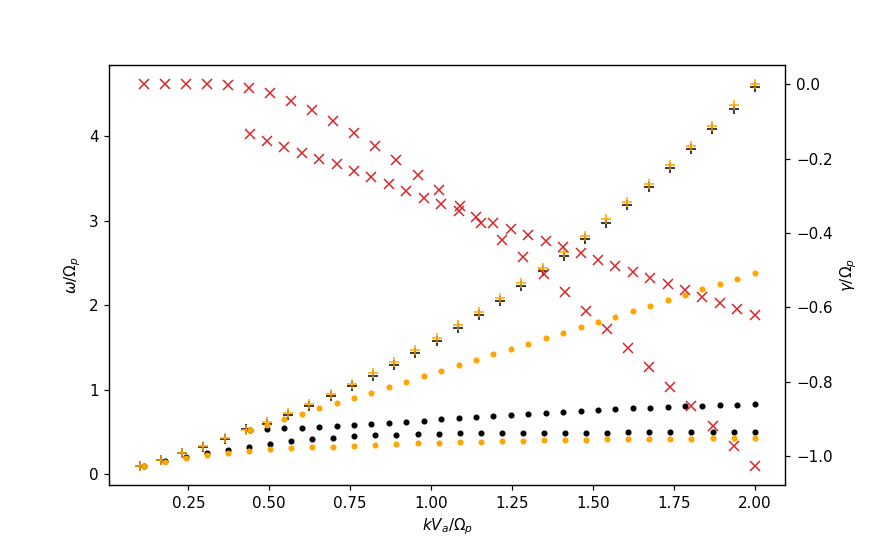

In [24]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(n_arr1/xpp, x1.real/xcp, '+', c='k')   
ax.plot(n_arr1/xpp, x1h.real/xcp, '+', c='orange')   
ax.plot(n_arr2/xpp, x2.real/xcp, '.', c='k')   
ax.plot(n_arr2/xpp, x2h.real/xcp, '.', c='orange')   
ax.plot(n_arr3/xpp, x3.real/xcp, '.', c='k')   
ax.plot(n_arr3/xpp, x3h.real/xcp, '.', c='orange')   

ax2 = ax.twinx()
#ax2.plot(n_arr1/xpp, x1.imag/xcp, 'x', c='C3')  
#ax2.plot(n_arr2/xpp, x2.imag/xcp, 'x', c='C3')  
ax2.plot(n_arr2/xpp, x2h.imag/xcp, 'x', c='C3')  
ax2.plot(n_arr3/xpp, x3h.imag/xcp, 'x', c='C3')  

ax.set_xlabel('$k V_a/\Omega_p$')
ax.set_ylabel('$\omega/\Omega_p$')
ax2.set_ylabel('$\gamma/\Omega_p$')

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(npara_arr/xpp, x1.real/xcp, c='k')   
ax.plot(npara_arr/xpp, x2.real/xcp, '+', c='cyan')   
ax2 = ax.twinx()
ax2.plot(npara_arr/xpp, x1.imag/xcp, c='C3')  
ax2.plot(npara_arr/xpp, x2.imag/xcp, '+', c='orange')   
ax.set_xlabel('$k V_a/\Omega_p$')
ax.set_ylabel('$\omega/\Omega_p$')
ax2.set_ylabel('$\gamma/\Omega_p$')

In [ ]:
x0 = np.array([.5, -.1])* xcp
sol = solverR2R2(nperp, npara, epsi_cold_e_p, x0)
sol.x / xcp

In [ ]:
npara_arr = np.linspace(npara, 6*npara, num=20)
nperp_arr = np.ones_like(npara_arr) * nperp

In [ ]:
x2 = oneBranch(nperp_arr, npara_arr, epsi_cold_e_p, x0)

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(npara_arr/xpp, x2.real/xcp, c='k')   
ax2 = ax.twinx()
ax2.plot(npara_arr/xpp, x2.imag/xcp, c='C3')   
ax.set_xlabel('$k V_a/\Omega_p$')
ax.set_ylabel('$\omega/\Omega_p$')
ax2.set_ylabel('$\gamma/\Omega_p$')

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(npara_arr/xpp, x1.real/xcp, c='k')
ax.plot(npara_arr/xpp, x2.real/xcp, c='blue')   

ax2 = ax.twinx()
ax2.plot(npara_arr/xpp, x1.imag/xcp, c='C3')   
ax.set_xlabel('$k_{\parallel} V_a/\Omega_p$')
ax.set_ylabel('$\omega/\Omega_p$')
ax2.set_ylabel('$\gamma/\Omega_p$')

In [ ]:
mu

In [ ]:
class Whampyr():
    def __init__(self, plasma, dispersion_function, solver, **solver_kwargs):
        self.plasma = plasma
        self.dispersion_function = dispersion_function
        self.solver = solver
        self.solver_kwargs = solver_kwargs

In [ ]:
for pop in pops:
    if pop.name == 'electron'
    break
    

In [ ]:
x, y = complex(1,3)

In [ ]:
complex(1,3)

In [ ]:
print(mp.mp)
mp.mp.dps = 15
print(mp.mp)

In [ ]:
npara = 2*xpp
nperp = npara/100.

#nperp = 0.1
#npara = 0.01
disp_1Dfunc1 = disp_1Dfunc_builder(nperp, npara, epsi_cold_e_p)
disp_1Dfunc2 = disp_1Dfunc_builder(nperp, npara, epsi_cold_e_hot_p)

In [ ]:
root1 = mp.findroot(disp_1Dfunc1, [xcp*.5 + 1j, xcp*.7], solver='muller')
root1 / xcp

In [ ]:
root2 = mp.findroot(disp_1Dfunc2, [xcp*.5 + 1j, xcp*.7], solver='muller')
root2 / xcp

In [ ]:
print(np.isclose(disp_1Dfunc2(root1.real), 0.0))
